# Predict Future Sales

This challenge serves as final project for the "How to win a data science competition" Coursera course. <br>
<br>
In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. <br>
<br>
<br>
- ID - an Id that represents a (Shop, Item) tuple within the test set <br> <br>
- shop_id - unique identifier of a shop <br> <br>
- item_id - unique identifier of a product<br> <br>
- item_category_id - unique identifier of item category<br> <br>
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure<br> <br>
- item_price - current price of an item<br> <br>
- date - date in format dd/mm/yyyy<br> <br>
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33<br> <br>
- item_name - name of item<br> <br>
- shop_name - name of shop<br> <br>
- item_category_name - name of item category<br> <br>

In [54]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns 
from tqdm import tqdm 
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error

In [55]:
# Download data

dossier = '/Users/augustincablant/Desktop/Kaggle/'

df_train = pd.read_csv(dossier+'sales_train.csv')

df_test = pd.read_csv(dossier+'test.csv')

items = pd.read_csv(dossier+'items.csv')

item_categories = pd.read_csv(dossier+'item_categories.csv')

shops = pd.read_csv(dossier+'shops.csv')

In [56]:
df_train['date'][0]

'02.01.2013'

In [60]:
df_train['date'] = pd.to_datetime(df_train['date'], format='d.%m.%Y')

ValueError: time data '02.01.2013' does not match format 'd.%m.%Y' (match)

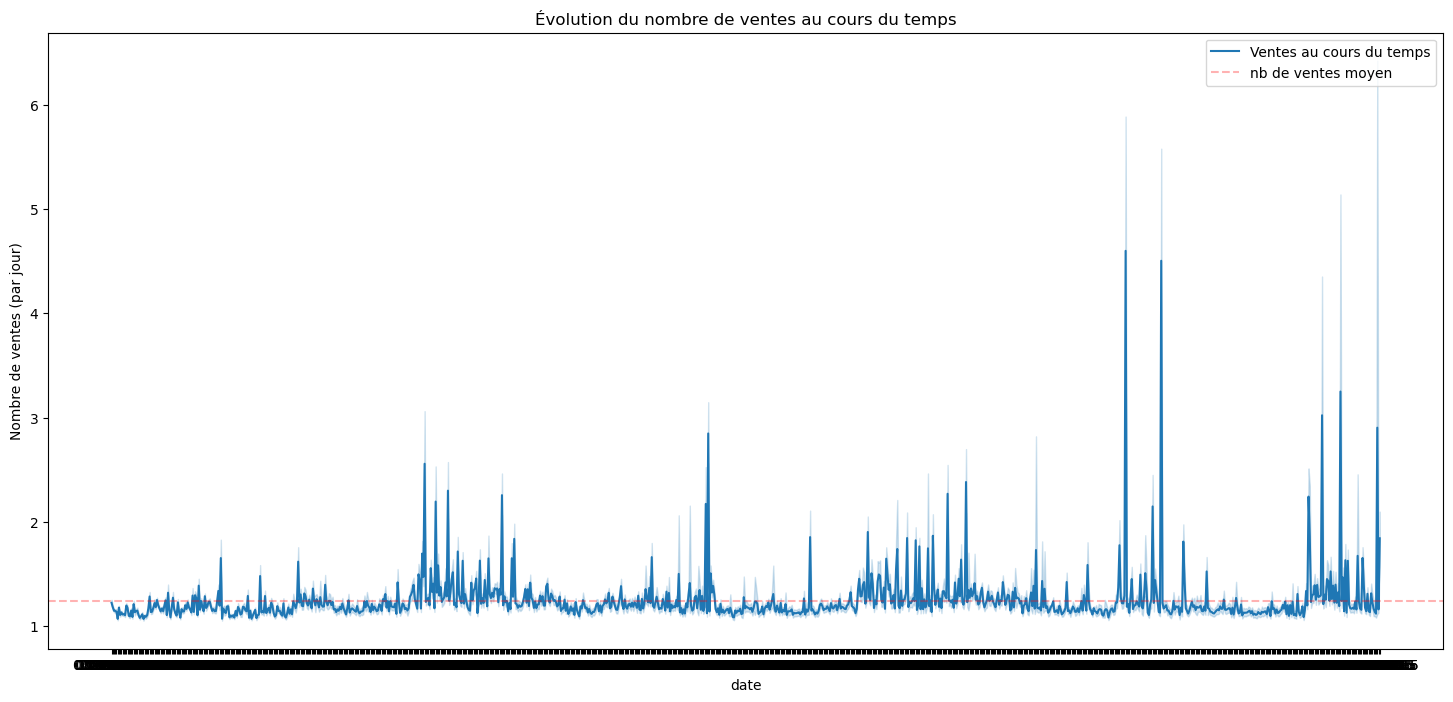

In [58]:
# display sales (per day)

plt.figure(figsize=(18, 8))
sns.lineplot(x= 'date', y= 'item_cnt_day', data=df_train, label='Ventes au cours du temps')
plt.axhline(df_train['item_cnt_day'].mean(), color='red', linestyle='--', alpha=0.3,label='nb de ventes moyen')
plt.xlabel('date')
plt.ylabel('Nombre de ventes (par jour)')
plt.title('Évolution du nombre de ventes au cours du temps')
plt.legend()
plt.show()

In [ ]:
df_train['year'] = df_train['date'].dt.year
df_train['mois'] = df_train['date'].dt.month
ventes_par_mois = df_train.groupby(['year', 'mois'])['item_cnt_day'].sum()

plt.figure(figsize=(10, 6))  
plt.bar(ventes_par_mois['mois'], ventes_par_mois['item_cnt_day'])
plt.xlabel('Mois')
plt.ylabel('Ventes')
plt.title('Évolution du nombre de ventes au cours du temps')
plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Aout', 'Sept', 'Oct', 'Nov', 'Dec'])
plt.show()

KeyError: 'mois'

<Figure size 1000x600 with 0 Axes>